In [1]:
import numpy as np
import pandas as pd
import math as m
import scipy as sp
import time
from scipy.stats import norm
import scipy.integrate as spi
import scipy.optimize as spopt
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp
from geneticalgorithm import geneticalgorithm as ga
from sko.PSO import PSO

In [2]:
np.random.seed(1)

# Data Processing

In [3]:
train = pd.read_csv('dec30.csv',usecols=[0,1,2,4,7,8,9])

In [4]:
train = train.dropna()
train

,date,symbol,exdate,strike_price,impl_volatility,mid,T
0,12/30/20,AAPL 210917C27500,9/17/21,27.50,0.871370,106.325,261.0
1,12/30/20,AAPL 210917C28750,9/17/21,28.75,0.847363,105.075,261.0
2,12/30/20,AAPL 210917C30000,9/17/21,30.00,0.824445,103.825,261.0
3,12/30/20,AAPL 210917C31250,9/17/21,31.25,0.802523,102.575,261.0
4,12/30/20,AAPL 210917C32500,9/17/21,32.50,0.781513,101.325,261.0
...,...,...,...,...,...,...,...
61,12/30/20,AAPL 210917C190000,9/17/21,190.00,0.374650,3.300,261.0
62,12/30/20,AAPL 210917C195000,9/17/21,195.00,0.377597,2.910,261.0
63,12/30/20,AAPL 210917C200000,9/17/21,200.00,0.381105,2.585,261.0
64,12/30/20,AAPL 210917C225000,9/17/21,225.00,0.402929,1.570,261.0


In [5]:
test = pd.read_csv('dec31.csv',usecols=[0,1,2,4,7,8,9])
test = test.dropna()
test

,date,symbol,exdate,strike_price,impl_volatility,mid,T
0,12/31/20,AAPL 210917C27500,9/17/21,27.50,0.937187,105.400,260.0
1,12/31/20,AAPL 210917C28750,9/17/21,28.75,0.923199,104.175,260.0
2,12/31/20,AAPL 210917C30000,9/17/21,30.00,0.898123,102.925,260.0
3,12/31/20,AAPL 210917C31250,9/17/21,31.25,0.874157,101.675,260.0
4,12/31/20,AAPL 210917C32500,9/17/21,32.50,0.851209,100.425,260.0
...,...,...,...,...,...,...,...
61,12/31/20,AAPL 210917C190000,9/17/21,190.00,0.366084,2.880,260.0
62,12/31/20,AAPL 210917C195000,9/17/21,195.00,0.368631,2.515,260.0
63,12/31/20,AAPL 210917C200000,9/17/21,200.00,0.373598,2.255,260.0
64,12/31/20,AAPL 210917C225000,9/17/21,225.00,0.397156,1.375,260.0


# Value Initialization

In [6]:
S1 = 132.90
S2 = 131.88

In [7]:
K1 = train.strike_price.tolist()
K2 = test.strike_price.tolist()

In [8]:
r = 0.0009
steps1 = 261
T1 = 261/365
steps2 = 260
T2 = 260/365

In [9]:
market_price1 = train.mid.tolist()
market_price2 = test.mid.tolist()
vol1 = train.impl_volatility.tolist()
vol2 = test.impl_volatility.tolist()

# Heston Model 

In [10]:
# Heston Model
def heston_model(S,T,r,steps,Npaths,k,theta,v_0,rho,xi):
    # S is stock price
    # T is time to maturity
    
    dt = T/steps
    stock = np.zeros((Npaths,steps))
    vol = np.zeros((Npaths,steps))
    S_t = S
    v_t = v_0
    for i in range(steps):
        W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),
                                          size = Npaths)*np.sqrt(dt)
        S_t = S_t*(np.exp((r-v_t*0.5)*dt +np.sqrt(v_t)*W[:,0]))
        v_t = np.maximum(v_t+k*(theta-v_t)*dt + xi*np.sqrt(v_t)*W[:,1],0)
        stock[:,i] = S_t
        vol[:,i] = v_t

    return stock, vol

#For downhill simplex method
def Heston_C(kappa, theta, sigma, rho, v0, r, T, s0, K):
    a = s0*Heston_P(kappa, theta, sigma, rho, v0, r, T, s0, K, 1)
    b = K*np.exp(-r*T)*Heston_P(kappa, theta, sigma, rho, v0, r, T, s0, K, 2)    
    return a-b   
def Heston_P(kappa, theta, sigma, rho, v0, r, T, s0, K, type):
    ifun = lambda phi: Int_Function_1(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type)
    return 0.5 + (1/np.pi)*spi.quad(ifun, 0, 100)[0]
def Int_Function_1(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type):
    temp = (np.exp(-1*1j*phi*np.log(K))*Int_Function_2(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type))    
    return temp   
def Int_Function_2(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type):
    if type==1:
        u = 0.5
        b = kappa - rho*sigma
    else: 
        u = -0.5
        b = kappa
    a = kappa*theta
    x = np.log(s0)
    d = np.sqrt((rho*sigma*phi*1j-b)**2 - sigma**2*(2*u*phi*1j-phi**2))
    g = (b-rho*sigma*phi*1j+d)/(b-rho*sigma*phi*1j-d)
    D = r*phi*1j*T + (a/sigma**2)*((b-rho*sigma*phi*1j+d)*T - 2*np.log((1-g*np.exp(d*T))/(1-g)))
    E = ((b-rho*sigma*phi*1j+d)/sigma**2)*(1-np.exp(d*T))/(1-g*np.exp(d*T))
    return np.exp(D + E*v0 + 1j*phi*x)
def Heston_Option_Values(K, kappa, theta, sigma, rho, v0, r, T, s0):
    HOV = np.zeros(len(K), dtype=np.float)
    for i in range(len(K)):
        HOV[i] = Heston_C(kappa, theta, sigma, rho, v0, r, T, s0, K[i])
    return HOV
def Error_Function(p0, K, price, s0, r, T):
    kappa, theta, sigma, rho, v0 = p0
    price_e = np.zeros(len(K), np.float)
    
    for i in range(len(K)):
        price_e[i] = Heston_C(kappa, theta, sigma, rho, v0, r, T, s0, K[i])
    RMSE = np.sqrt(np.sum(price-price_e)**2/len(price))
    return RMSE

# Black-Scholes Model

In [11]:
#BS Model
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

In [12]:
# Calculate bs price of test set
bs_price = []
for i in range(len(K2)):
    p = bs_call(S2,K2[i],T2,r,vol2[i])
    bs_price.append(p)

# Calibration

In [13]:
# Error function for optimization
def RMSE(true,predict):
    mse = np.square(np.subtract(true,predict)).mean()
    rmse = m.sqrt(mse)
    return rmse

## Tree-structured Parzen Estimator

In [14]:
# heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
def tpe_opt(market_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(parameters):
        s,v = heston_model(S,T,r,steps,Npaths,**parameters)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return rmse
    space = {
        'k': hp.uniform('k',0.0001,1),
        'theta': hp.uniform('theta',0.0001,1),
        'v_0': hp.uniform('v_0',0.0001,1),
        'rho': hp.uniform('rho',-1,1),
        'xi': hp.uniform('xi',0.0001,5)
    }
    best = fmin(
        fn = objective,
        space = space,
        algo = tpe.suggest,
        max_evals = 1000
        )
    print(best)

In [15]:
tpe_opt(market_price1,S1,K1,T1,r,steps1,10000)

100%|██████████| 1000/1000 [04:08<00:00,  4.02trial/s, best loss: 0.49889570706281255]
{'k': 0.3957150750709376, 'rho': -0.27344045547271945, 'theta': 0.7136683952530855, 'v_0': 0.0691918961343978, 'xi': 1.2329724201822125}


In [15]:
para = {'k': 0.3957150750709376, 'rho': -0.27344045547271945, 'theta': 0.7136683952530855, 'v_0': 0.0691918961343978, 'xi': 1.2329724201822125}

In [16]:
s,v = heston_model(S2,T2,r,steps2,10000,**para)
P = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P[:,i] = np.maximum(s[:,-1] - K2[i],0)

P = np.mean(P,axis = 0)
tpe_call_price = P*np.exp(-r*1)
tpe_call_price = tpe_call_price.tolist()
print(tpe_call_price)

[104.44271027189976, 103.20022497135868, 101.95844903974977, 100.71746859383738, 99.47711007234757, 98.23762543190219, 96.99866295662089, 95.76043670041322, 94.52308773769305, 93.28691550078943, 92.05258179484564, 90.82003046066177, 89.58881450448243, 88.35945489488302, 87.13199305139459, 85.90644500245934, 84.68263756421983, 83.46052869089513, 82.23983177815404, 79.805151691208, 77.38016526837187, 74.96616782353573, 72.564149761991, 70.17478500820606, 67.79694208659986, 65.4334447729461, 63.08831460881775, 60.76073788623873, 58.449697225811626, 56.15519927444529, 53.8794218108572, 51.626093410931425, 49.39999134097754, 47.19794924291645, 45.02123405839016, 42.871563637269226, 40.750636749703304, 38.66405455037936, 36.61773676023655, 34.61209037829709, 32.649425550989484, 30.73359706572405, 28.86687412417964, 27.052692845114098, 25.29461374215644, 23.59664267782264, 21.962317414644716, 20.396881806492804, 18.90499540590155, 16.149974592401016, 13.714013676951541, 11.619348464076355, 9.

## Bayesian Optimization

In [17]:
def bay_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    t1 = time.time()
    def objective(k,theta,v_0,rho,xi):
        s,v = heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return -rmse
    pbounds = {
        'k': (0.0001,1),
        'theta': (0.0001,1),
        'v_0': (0.0001,1),
        'rho': (-1,1),
        'xi': (0.0001,5)
    }
    optimizer = BayesianOptimization(
        f = objective,
        pbounds = pbounds,
        random_state=1111,
        )
    optimizer.maximize(init_points=20, n_iter=1000)
    t2 = time.time()
    print(optimizer.max)
    print(t2-t1)

In [19]:
bay_opt(market_price1,S1,K1,T1,r,steps1,10000)

|   iter    |  target   |     k     |    rho    |   theta   |    v_0    |    xi     |
-------------------------------------------------------------------------------------
|  1        | -4.512    |  0.09564  |  0.85     |  0.3436   |  0.3105   |  0.01015  |
|  2        | -4.632    |  0.2357   | -0.5244   |  0.7359   |  0.4955   |  3.922    |
|  3        | -3.164    |  0.1266   |  0.2133   |  0.4662   |  0.2372   |  2.176    |
|  4        | -10.87    |  0.2437   | -0.2323   |  0.8384   |  0.6552   |  0.7423   |
|  5        | -14.12    |  0.6392   |  0.2747   |  0.6109   |  0.93     |  4.083    |
|  6        | -5.212    |  0.7694   | -0.8292   |  0.665    |  0.7117   |  4.437    |
|  7        | -3.076    |  0.2681   | -0.5138   |  0.7893   |  0.378    |  3.972    |
|  8        | -8.034    |  0.8673   |  0.5916   |  0.9172   |  0.2712   |  3.804    |
|  9        | -1.998    |  0.6304   | -0.8413   |  0.1309   |  0.3004   |  1.611    |
|  10       | -6.879    |  0.1612   | -0.3696   |  0.5

|  58       | -4.172    |  0.7339   | -0.7524   |  0.0001   |  0.0001   |  5.0      |
|  59       | -4.732    |  0.8242   | -0.2395   |  0.0001   |  0.0001   |  4.101    |
|  60       | -6.172    |  0.3319   | -1.0      |  0.0001   |  0.0001   |  0.3203   |
|  61       | -3.487    |  0.0001   | -1.0      |  0.7073   |  0.236    |  4.262    |
|  62       | -4.293    |  0.0001   | -0.368    |  1.0      |  0.0001   |  3.939    |
|  63       | -3.29     |  0.0001   | -0.4083   |  1.0      |  0.0001   |  5.0      |
|  64       | -3.477    |  1.0      | -0.3561   |  0.0001   |  0.1307   |  2.166    |
|  65       | -2.905    |  1.0      | -1.0      |  1.0      |  0.0001   |  5.0      |
|  66       | -12.85    |  0.2572   | -0.0972   |  0.9213   |  0.9799   |  3.167    |
|  67       | -2.525    |  1.0      | -1.0      |  1.0      |  0.0001   |  4.133    |
|  68       | -6.214    |  0.7274   |  1.0      |  0.0001   |  0.0001   |  0.0001   |
|  69       | -6.209    |  0.1356   |  0.3366   |  0.9

|  116      | -2.091    |  1.0      | -0.3749   |  0.8464   |  0.0001   |  3.239    |
|  117      | -12.63    |  1.0      |  1.0      |  0.0001   |  1.0      |  5.0      |
|  118      | -3.32     |  0.1964   |  0.7048   |  0.1753   |  0.1959   |  1.242    |
|  119      | -2.687    |  1.0      | -0.4504   |  0.6384   |  0.0001   |  5.0      |
|  120      | -3.301    |  0.6262   | -0.493    |  0.06099  |  0.5617   |  2.634    |
|  121      | -2.518    |  0.1642   | -0.6422   |  0.1446   |  0.259    |  0.5533   |
|  122      | -2.767    |  0.9693   | -0.9806   |  0.08393  |  0.5743   |  2.832    |
|  123      | -6.864    |  0.551    | -0.2936   |  0.5926   |  0.6269   |  2.802    |
|  124      | -1.882    |  0.5117   | -0.4752   |  0.3555   |  0.1077   |  0.8899   |
|  125      | -3.315    |  0.4435   |  0.2366   |  0.3895   |  0.0001   |  1.426    |
|  126      | -2.561    |  0.1431   | -0.4043   |  0.5182   |  0.3597   |  2.022    |
|  127      | -7.823    |  0.1241   | -0.431    |  0.4

|  174      | -10.72    |  1.0      |  1.0      |  1.0      |  0.0001   |  5.0      |
|  175      | -1.611    |  1.0      | -0.5263   |  0.642    |  0.0001   |  4.003    |
|  176      | -2.943    |  1.0      | -0.555    |  1.0      |  0.0001   |  4.599    |
|  177      | -3.723    |  1.0      | -1.0      |  0.6873   |  0.4385   |  2.718    |
|  178      | -1.84     |  1.0      | -0.5885   |  0.5588   |  0.0001   |  0.9518   |
|  179      | -1.326    |  0.5923   | -0.3472   |  0.6028   |  0.1534   |  2.04     |
|  180      | -2.359    |  0.4502   | -0.0482   |  0.0001   |  0.3459   |  5.0      |
|  181      | -4.892    |  1.0      |  1.0      |  1.0      |  0.0001   |  1.365    |
|  182      | -1.831    |  1.0      | -0.2463   |  0.5356   |  0.0001   |  3.628    |
|  183      | -6.466    |  1.0      | -1.0      |  1.0      |  1.0      |  5.0      |
|  184      | -1.233    |  1.0      | -0.5236   |  0.0001   |  0.4346   |  5.0      |
|  185      | -1.206    |  0.0001   | -0.3838   |  0.0

|  232      | -2.26     |  1.0      | -1.0      |  1.0      |  0.0001   |  2.057    |
|  233      | -1.298    |  0.477    | -0.1506   |  1.0      |  0.0001   |  2.617    |
|  234      | -3.245    |  1.0      | -0.03466  |  1.0      |  0.0001   |  2.208    |
|  235      | -1.509    |  0.2378   | -0.3908   |  0.4332   |  0.2011   |  1.489    |
|  236      | -1.491    |  0.621    | -0.5492   |  0.914    |  0.005455 |  3.429    |
|  237      | -1.499    |  1.0      | -0.6143   |  0.0001   |  0.3686   |  1.781    |
|  238      | -2.21     |  0.448    | -0.2369   |  0.7388   |  0.1966   |  2.316    |
|  239      | -1.263    |  0.4075   | -0.3863   |  1.0      |  0.0001   |  2.944    |
|  240      | -1.708    |  0.8935   | -0.3763   |  0.0001   |  0.3117   |  3.369    |
|  241      | -1.911    |  0.6428   | -0.2151   |  1.0      |  0.0001   |  2.979    |
|  242      | -1.415    |  0.3701   | -0.3344   |  0.5948   |  0.02857  |  3.263    |
|  243      | -1.36     |  0.559    | -0.6158   |  0.6

|  290      | -1.308    |  0.1661   | -0.3641   |  1.0      |  0.0001   |  4.524    |
|  291      | -1.979    |  0.4653   | -0.2675   |  0.0001   |  0.2222   |  3.414    |
|  292      | -2.159    |  1.0      | -0.5356   |  1.0      |  0.0001   |  2.611    |
|  293      | -1.954    |  0.6685   |  0.08148  |  0.0001   |  0.2709   |  3.313    |
|  294      | -2.399    |  0.3569   | -0.1862   |  1.0      |  0.0001   |  4.789    |
|  295      | -1.699    |  0.3086   | -0.2624   |  0.3635   |  0.2467   |  1.659    |
|  296      | -1.941    |  1.0      | -0.6053   |  0.0001   |  0.6848   |  5.0      |
|  297      | -1.89     |  0.0001   | -0.3279   |  1.0      |  0.257    |  4.56     |
|  298      | -1.317    |  0.0001   | -0.5022   |  0.2106   |  0.3061   |  3.583    |
|  299      | -1.96     |  0.7329   | -0.8361   |  0.7375   |  0.0001   |  4.822    |
|  300      | -3.568    |  0.0001   |  0.01726  |  1.0      |  0.0001   |  4.576    |
|  301      | -1.252    |  0.7032   | -0.5532   |  0.0

|  348      | -1.249    |  0.7811   | -0.5196   |  0.0001   |  0.3841   |  4.747    |
|  349      | -1.898    |  0.8242   | -0.318    |  0.03843  |  0.2606   |  2.947    |
|  350      | -1.869    |  0.4519   | -0.4208   |  0.5313   |  0.0001   |  4.422    |
|  351      | -1.676    |  0.6095   | -0.7118   |  0.5444   |  0.1877   |  2.731    |
|  352      | -4.166    |  0.364    |  1.0      |  0.4848   |  0.0001   |  0.8517   |
|  353      | -2.19     |  0.08061  | -0.5212   |  0.318    |  0.1412   |  3.306    |
|  354      | -1.226    |  1.0      | -0.5486   |  0.2937   |  0.0001   |  4.55     |
|  355      | -1.548    |  0.6918   | -0.6875   |  0.4564   |  0.02436  |  4.456    |
|  356      | -1.471    |  0.3866   | -0.1507   |  0.168    |  0.2476   |  2.253    |
|  357      | -1.652    |  0.3587   |  0.01184  |  1.0      |  0.0001   |  0.0001   |
|  358      | -2.107    |  1.0      | -0.5657   |  0.0001   |  0.3063   |  4.451    |
|  359      | -3.171    |  0.4097   |  0.158    |  0.6

|  406      | -1.763    |  1.0      | -0.6345   |  0.7806   |  0.0001   |  2.056    |
|  407      | -1.775    |  0.6555   | -0.03714  |  0.0001   |  0.2666   |  2.267    |
|  408      | -6.043    |  1.0      | -1.0      |  0.0001   |  1.0      |  2.17     |
|  409      | -1.647    |  0.7079   | -0.6875   |  1.0      |  0.0001   |  1.796    |
|  410      | -2.004    |  0.8406   |  0.2806   |  0.7194   |  0.0001   |  0.6178   |
|  411      | -1.539    |  0.0001   | -0.6105   |  0.2311   |  0.3985   |  4.167    |
|  412      | -2.437    |  0.7903   |  0.6199   |  0.7219   |  0.0001   |  0.8743   |
|  413      | -1.967    |  0.7423   | -0.8312   |  0.3098   |  0.2468   |  2.557    |
|  414      | -1.98     |  0.6051   |  0.01087  |  1.0      |  0.0001   |  0.09111  |
|  415      | -1.667    |  0.2971   | -0.4935   |  1.0      |  0.0001   |  4.707    |
|  416      | -1.144    |  0.6896   | -0.4677   |  0.7724   |  0.005542 |  2.829    |
|  417      | -4.485    |  0.0001   | -0.7192   |  1.0

|  464      | -2.239    |  0.7844   | -0.4609   |  0.05183  |  0.3872   |  1.553    |
|  465      | -6.091    |  0.1284   |  0.9244   |  0.9448   |  0.09206  |  3.628    |
|  466      | -2.567    |  0.3305   | -0.3228   |  0.3825   |  0.06665  |  0.2007   |
|  467      | -1.699    |  1.0      | -0.2759   |  0.0001   |  0.4364   |  5.0      |
|  468      | -1.944    |  0.8971   | -0.7852   |  0.001177 |  0.5424   |  3.235    |
|  469      | -1.614    |  0.4113   | -0.4591   |  0.2361   |  0.2928   |  3.286    |
|  470      | -1.615    |  0.7385   | -0.5937   |  0.8464   |  0.0487   |  3.156    |
|  471      | -3.204    |  0.5596   | -0.3596   |  0.0001   |  0.4029   |  4.84     |
|  472      | -1.291    |  0.0001   | -0.5028   |  0.2326   |  0.2862   |  2.407    |
|  473      | -3.026    |  0.4679   | -0.9912   |  0.1637   |  0.6011   |  4.982    |
|  474      | -2.12     |  1.0      |  0.09943  |  0.4593   |  0.0001   |  2.435    |
|  475      | -1.5      |  0.5872   | -0.2366   |  0.0

|  522      | -2.493    |  0.5767   | -1.0      |  1.0      |  0.0001   |  5.0      |
|  523      | -1.605    |  1.0      | -0.612    |  0.4889   |  0.0001   |  4.625    |
|  524      | -7.263    |  0.9788   | -0.4151   |  0.5801   |  0.5339   |  1.222    |
|  525      | -1.568    |  0.6831   | -0.03866  |  0.4459   |  0.0001   |  3.71     |
|  526      | -9.507    |  0.5981   |  0.5726   |  0.1877   |  0.6404   |  0.981    |
|  527      | -13.32    |  0.961    |  0.798    |  0.7851   |  0.3163   |  4.918    |
|  528      | -1.504    |  0.5041   | -0.6344   |  1.0      |  0.0001   |  3.114    |
|  529      | -6.202    |  0.0001   | -0.628    |  0.1448   |  0.0001   |  0.0001   |
|  530      | -15.66    |  1.0      | -1.0      |  1.0      |  1.0      |  0.0001   |
|  531      | -1.755    |  0.0001   | -0.5573   |  0.6281   |  0.3458   |  2.317    |
|  532      | -1.69     |  0.6322   | -0.5664   |  0.8649   |  0.1169   |  1.627    |
|  533      | -1.471    |  0.8046   | -0.2842   |  0.0

|  580      | -1.605    |  0.4333   | -0.1343   |  1.0      |  0.0001   |  2.85     |
|  581      | -1.896    |  0.849    | -1.0      |  0.7583   |  0.0001   |  1.246    |
|  582      | -3.628    |  0.0001   | -0.4637   |  0.8738   |  0.0001   |  4.529    |
|  583      | -3.631    |  0.2047   | -0.2747   |  0.7531   |  0.2402   |  4.54     |
|  584      | -4.172    |  0.0001   | -1.0      |  1.0      |  1.0      |  5.0      |
|  585      | -1.416    |  0.2031   | -0.6067   |  0.326    |  0.2502   |  2.574    |
|  586      | -1.474    |  0.0001   | -0.5749   |  1.0      |  0.3005   |  4.752    |
|  587      | -1.344    |  0.0001   | -0.5827   |  0.4926   |  0.3523   |  4.326    |
|  588      | -1.96     |  0.0001   | -0.6717   |  0.6383   |  0.284    |  5.0      |
|  589      | -2.559    |  0.0001   | -0.6139   |  0.0001   |  0.1837   |  2.445    |
|  590      | -1.629    |  0.9911   | -0.6836   |  0.4565   |  0.1461   |  1.725    |
|  591      | -2.279    |  0.5311   |  1.0      |  0.8

|  638      | -3.733    |  1.0      | -1.0      |  0.0001   |  0.1128   |  0.6815   |
|  639      | -2.536    |  0.4773   | -0.6868   |  0.0001   |  0.2031   |  4.337    |
|  640      | -1.677    |  0.0001   | -0.668    |  1.0      |  0.4768   |  5.0      |
|  641      | -4.243    |  1.0      | -1.0      |  0.0001   |  0.5842   |  1.01     |
|  642      | -2.436    |  0.5966   | -0.6067   |  0.004353 |  0.1915   |  0.816    |
|  643      | -1.916    |  0.3356   |  0.1233   |  1.0      |  0.0001   |  2.438    |
|  644      | -1.216    |  0.6717   | -0.4971   |  0.1811   |  0.2094   |  3.811    |
|  645      | -1.833    |  0.5166   | -0.6431   |  1.0      |  0.0001   |  2.121    |
|  646      | -2.603    |  0.574    | -1.0      |  0.5939   |  0.2439   |  5.0      |
|  647      | -2.324    |  0.2714   |  0.2032   |  0.5923   |  0.1398   |  2.984    |
|  648      | -1.786    |  0.4244   | -0.05197  |  0.3255   |  0.1727   |  3.147    |
|  649      | -2.662    |  0.4896   |  0.3578   |  0.5

|  696      | -1.854    |  0.593    | -0.05943  |  0.4748   |  0.0001   |  4.203    |
|  697      | -3.027    |  1.0      |  0.2004   |  0.0001   |  0.4378   |  4.057    |
|  698      | -6.049    |  0.0001   |  1.0      |  0.6806   |  0.0001   |  0.4337   |
|  699      | -8.112    |  0.7433   |  0.3222   |  0.5026   |  0.6758   |  2.976    |
|  700      | -1.465    |  0.1158   | -0.6361   |  0.1387   |  0.2657   |  4.645    |
|  701      | -2.075    |  0.2522   | -0.1106   |  0.476    |  0.0001   |  3.637    |
|  702      | -1.381    |  0.419    | -0.2389   |  0.4357   |  0.0001   |  4.032    |
|  703      | -1.601    |  0.8384   | -0.6402   |  0.349    |  0.1384   |  3.817    |
|  704      | -2.257    |  0.1316   | -0.1955   |  0.5114   |  0.2162   |  4.024    |
|  705      | -1.932    |  0.0001   | -0.5527   |  0.0001   |  0.5618   |  5.0      |
|  706      | -1.667    |  0.4753   | -0.7143   |  0.4481   |  0.0001   |  4.712    |
|  707      | -6.959    |  0.62     | -0.2842   |  0.5

|  754      | -1.851    |  0.4911   | -0.3493   |  0.4079   |  0.1417   |  3.011    |
|  755      | -1.437    |  0.1806   | -0.4674   |  0.165    |  0.2992   |  2.83     |
|  756      | -2.233    |  0.0001   | -0.6      |  0.7491   |  0.5155   |  4.891    |
|  757      | -1.714    |  0.09552  | -0.2418   |  0.2901   |  0.2227   |  3.097    |
|  758      | -6.166    |  0.000985 |  0.4483   |  0.8164   |  0.4335   |  1.104    |
|  759      | -2.161    |  0.6672   | -0.9404   |  0.7049   |  0.1336   |  2.371    |
|  760      | -1.681    |  0.0001   | -0.2892   |  1.0      |  0.3359   |  5.0      |
|  761      | -2.297    |  0.5332   | -0.8125   |  0.4849   |  0.3369   |  4.024    |
|  762      | -2.425    |  0.1145   | -0.508    |  1.0      |  0.2766   |  5.0      |
|  763      | -2.299    |  1.0      | -0.3266   |  0.2388   |  0.2015   |  5.0      |
|  764      | -1.439    |  0.7919   | -0.1348   |  0.5026   |  0.09479  |  2.256    |
|  765      | -1.812    |  0.0001   | -0.6861   |  0.1

|  812      | -3.505    |  0.8588   |  0.332    |  0.1639   |  0.2486   |  3.559    |
|  813      | -1.109    |  0.5689   | -0.495    |  0.5197   |  0.1185   |  3.025    |
|  814      | -7.826    |  0.8966   |  0.1399   |  0.7792   |  0.5563   |  4.701    |
|  815      | -5.76     |  1.0      | -0.04301  |  1.0      |  0.0001   |  5.0      |
|  816      | -2.954    |  0.8287   | -0.2322   |  0.02016  |  0.0678   |  3.638    |
|  817      | -3.56     |  0.9727   |  0.4366   |  0.01466  |  0.0273   |  4.517    |
|  818      | -5.013    |  0.1677   |  0.3444   |  0.01408  |  0.5045   |  4.818    |
|  819      | -10.39    |  0.5239   | -0.1235   |  0.2328   |  0.7822   |  1.327    |
|  820      | -8.897    |  0.9226   |  0.1907   |  0.1505   |  0.7466   |  1.197    |
|  821      | -2.043    |  0.5873   | -0.6293   |  0.3329   |  0.3227   |  1.839    |
|  822      | -12.07    |  1.0      | -0.3474   |  0.0001   |  1.0      |  0.0001   |
|  823      | -5.334    |  0.2844   |  0.5874   |  0.7

|  870      | -11.84    |  0.9168   | -0.8424   |  0.3774   |  0.8299   |  0.1355   |
|  871      | -2.406    |  0.0001   |  0.01065  |  0.2697   |  0.1759   |  3.258    |
|  872      | -1.17     |  0.7009   | -0.5161   |  0.0001   |  0.3431   |  3.132    |
|  873      | -1.926    |  0.7006   | -1.0      |  1.0      |  0.0001   |  0.6774   |
|  874      | -1.552    |  0.6917   |  0.191    |  0.3627   |  0.02938  |  3.021    |
|  875      | -6.322    |  0.3959   |  0.6793   |  0.9142   |  0.2213   |  3.825    |
|  876      | -1.959    |  0.2695   | -0.7323   |  0.1488   |  0.3959   |  3.349    |
|  877      | -2.698    |  0.228    | -1.0      |  0.6206   |  0.1695   |  1.674    |
|  878      | -1.772    |  0.3644   | -0.2577   |  0.6504   |  0.0001   |  5.0      |
|  879      | -2.642    |  0.2569   | -1.0      |  0.3388   |  0.3326   |  3.837    |
|  880      | -1.924    |  1.0      | -0.6543   |  0.0001   |  0.3859   |  1.323    |
|  881      | -13.13    |  0.1434   |  0.4516   |  0.8

|  928      | -7.082    |  0.03674  | -0.6154   |  0.3637   |  0.7433   |  1.792    |
|  929      | -2.871    |  0.6294   |  0.7275   |  0.225    |  0.01264  |  2.799    |
|  930      | -11.48    |  0.08608  |  0.6994   |  0.5295   |  0.9395   |  3.559    |
|  931      | -1.53     |  0.8437   | -0.4122   |  0.1489   |  0.3053   |  2.47     |
|  932      | -5.75     |  1.0      |  1.0      |  0.2286   |  0.0001   |  2.87     |
|  933      | -1.798    |  0.8324   | -0.1345   |  0.5081   |  0.0001   |  0.2508   |
|  934      | -2.072    |  0.7694   |  0.3846   |  0.3475   |  0.0001   |  2.713    |
|  935      | -1.826    |  0.5668   | -0.4599   |  1.0      |  0.0001   |  1.194    |
|  936      | -1.869    |  1.0      | -0.06984  |  0.5803   |  0.0001   |  0.0001   |
|  937      | -3.233    |  0.02618  | -0.2492   |  0.03495  |  0.1557   |  2.986    |
|  938      | -2.196    |  0.4602   |  0.04404  |  0.05129  |  0.2626   |  2.856    |
|  939      | -15.62    |  0.4636   |  0.9343   |  0.8

|  986      | -1.733    |  0.0001   | -0.6827   |  0.0001   |  0.247    |  1.55     |
|  987      | -3.674    |  0.1634   | -0.4295   |  0.0001   |  0.0001   |  5.0      |
|  988      | -3.735    |  0.5013   |  0.00427  |  0.9258   |  0.1385   |  0.1166   |
|  989      | -2.435    |  0.06674  |  0.4615   |  0.7806   |  0.09122  |  2.195    |
|  990      | -2.253    |  0.3635   |  0.5709   |  0.7752   |  0.0001   |  2.299    |
|  991      | -2.65     |  0.6908   | -0.7443   |  0.723    |  0.1219   |  0.332    |
|  992      | -7.562    |  0.558    | -0.01853  |  0.2114   |  0.4929   |  0.2994   |
|  993      | -2.312    |  1.0      | -0.06124  |  0.716    |  0.0001   |  0.2884   |
|  994      | -16.84    |  0.2236   |  0.131    |  0.539    |  0.9556   |  4.13     |
|  995      | -2.323    |  0.0001   | -0.2702   |  0.1735   |  0.3428   |  2.825    |
|  996      | -2.458    |  0.6137   | -0.7719   |  1.0      |  0.0001   |  0.0001   |
|  997      | -4.994    |  0.0001   |  0.2226   |  1.0

In [18]:
para2 = {'k': 0.29101709291197747, 'rho': -0.36547962800681605, 'theta': 1.0, 'v_0': 0.07966348581183556, 'xi': 2.10497616538837}

In [19]:
s2,v2 = heston_model(S2,T2,r,steps2,10000,**para2)
P2 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P2[:,i] = np.maximum(s2[:,-1] - K2[i],0)

P2 = np.mean(P2,axis = 0)
bayes_call_price = P2*np.exp(-r*1)
bayes_call_price = bayes_call_price.tolist()
print(bayes_call_price)

[104.19792036044971, 102.96499846894136, 101.7333288109211, 100.50326557408614, 99.27504599363894, 98.0483452409069, 96.82319103964474, 95.60008851665627, 94.37877085396164, 93.15937017080938, 91.9417756355069, 90.72629339429878, 89.51327477360289, 88.30217349389844, 87.09301677520884, 85.8860601711131, 84.6812932917925, 83.47840764818145, 82.27817109086888, 79.88495256801309, 77.50032318532192, 75.12775479112888, 72.76602593480864, 70.41336284518283, 68.07191144756192, 65.7419412290913, 63.42399567470779, 61.11850904069031, 58.83085340851247, 56.5606053923502, 54.30441707902652, 52.06829288183584, 49.8527977676355, 47.659128442683404, 45.490942313768365, 43.34832397612924, 41.23309607434235, 39.147753135476286, 37.095223977211155, 35.07807840003766, 33.09619119567483, 31.14919931699224, 29.24273044532572, 27.381340952146886, 25.570406548230235, 23.81200216732903, 22.117228587365613, 20.489863881988846, 18.9328639420891, 16.048462529904416, 13.500004061354245, 11.321090332757043, 9.477

## Genetic Algorithm

In [20]:
def ga_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    t1 = time.time()
    def objective(X):
        s,v = heston_model(S,T,r,steps, Npaths,X[0],X[1],X[2],X[3],X[4])
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return rmse
    varbound = np.array([[0,1],[0,1],[0,1],[-1,1],[0,5]])
    algorithm_param = {'max_num_iteration': 200,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None}

    model = ga(function=objective,dimension=5,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)
    model.run()
    t2 = time.time()
    print(t2-t1)

 The best solution found:                                                                           
 [ 0.09624786  0.41633802  0.16537257 -0.34097837  1.01848823]

 Objective function:
 0.6902971589823489


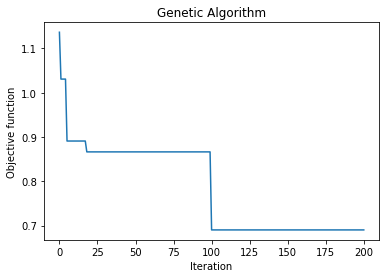

3374.996951818466


In [23]:
ga_opt(market_price1,S1,K1,T1,r,steps1,10000)

In [21]:
#para3 = {'k': 0.00073419, 'rho': 0.06236637, 'theta': 0.00405447, 'v_0': 0.01519778, 'xi': 0.24350673}
para3 = {'k': 0.09624786, 'rho': -0.34097837, 'theta': 0.41633802, 'v_0': 0.16537257, 'xi': 1.01848823}

In [22]:
s3,v3 = heston_model(S2,T2,r,steps2,10000,**para3)
P3 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P3[:,i] = np.maximum(s3[:,-1] - K2[i],0)

P3 = np.mean(P3,axis = 0)
ga_call_price = P3*np.exp(-r*1)
ga_call_price = ga_call_price.tolist()
print(ga_call_price)

[104.72339059617407, 103.48283032255225, 102.24367141465437, 101.00568674546129, 99.7688596624746, 98.5330384202108, 97.29832500816624, 96.06457299617948, 94.83209461177206, 93.60078691578853, 92.37042003021512, 91.14133618881327, 89.91434620563831, 88.69013181330253, 87.46833906910855, 86.24784297052852, 85.02903485636425, 83.81216773212884, 82.5977722223351, 80.17801509835455, 77.7699412177592, 75.37426238246967, 72.98929706075558, 70.61643991058098, 68.25820576714452, 65.91701981935408, 63.590457409829625, 61.282351076807544, 58.99670896091071, 56.73294893683156, 54.48701064781421, 52.263916374882136, 50.064974253781834, 47.891318448974104, 45.7462404367351, 43.63636503702701, 41.55559717124641, 39.5044845858776, 37.492349373235974, 35.51848155802729, 33.58640701685348, 31.695025773864813, 29.847774299222234, 28.04896244502631, 26.304245399906364, 24.61442781210538, 22.98232657982323, 21.41390719661532, 19.9093496668576, 17.123887121440923, 14.649603823536168, 12.5137082924517, 10.6

## Downhill Simplex Algorithm

In [23]:
price = market_price1
t1 = time.time()
p0 = np.array([1.0, 0.05, 0.15,-0.7, 0.04]) # initial guess for parameters
opt = spopt.fmin(Error_Function, p0, maxiter=75, maxfun=75, args=(K1, price, S1, r, T1))
t2 = time.time()
print(opt)
print(t2-t1)

<ipython-input-10-372b054bd36f>:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price_e = np.zeros(len(K), np.float)
/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


[ 1.08965979  0.05620208  0.17126824 -1.06209853  0.01828358]
208.34584712982178


In [24]:
para4 = {'k':1.08965979 , 'rho':-1.06209853 , 'theta':0.05620208 , 'v_0':0.01828358, 'xi':0.17126824}

In [25]:
s4,v4 = heston_model(S2,T2,r,steps2,10000,**para4)
P4 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P4[:,i] = np.maximum(s4[:,-1] - K2[i],0)

P4 = np.mean(P4,axis = 0)
ds_call_price = P4*np.exp(-r*1)
ds_call_price = ds_call_price.tolist()
print(ds_call_price)

<ipython-input-10-372b054bd36f>:9: RuntimeWarning: covariance is not positive-semidefinite.
  W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),


[104.35636263016798, 103.10748712406978, 101.85861161797165, 100.60973611187352, 99.36086060577536, 98.11198509967723, 96.86310959357913, 95.61423408748098, 94.36535858138271, 93.11648307528455, 91.86760756918639, 90.61873206308817, 89.36985655699002, 88.12098105089181, 86.87210554479358, 85.62323003869547, 84.37435453259728, 83.1254790264991, 81.87660352040099, 79.37885250820467, 76.88131819222485, 74.38422359050612, 71.88740682833821, 69.39088147052009, 66.89481204532422, 64.39920686583078, 61.904513990413456, 59.411843966198965, 56.92185232723637, 54.434916664696914, 51.953218010236256, 49.47867607544841, 47.01222102477396, 44.55497616411265, 42.10829879128161, 39.676394492073776, 37.2646696196425, 34.87435927535773, 32.51003803088709, 30.18150092554984, 27.89052906846126, 25.64225795184863, 23.441479316956364, 21.30174909122905, 19.233374674246992, 17.24482199594118, 15.340036768151158, 13.530047716739734, 11.82832712152671, 8.76629497146287, 6.1635069791599815, 4.080856948452423, 

## Particle Swarm Optimization

In [26]:
def pso_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    t1 = time.time()
    def objective(k,theta,v_0,rho,xi):
        s,v = heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)


        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return rmse
    pso = PSO(func=objective, n_dim=5, pop=40, max_iter=150, lb = [0.0001, 0.0001, 0.0001,-1,0.0001],
    ub = [1, 1, 1,1,5])
    pso.run()
    t2 = time.time()
    print(pso.gbest_x)
    print(t2-t1)

In [27]:
pso_opt(market_price1,S1,K1,T1,r,steps1,10000)

/opt/anaconda3/lib/python3.8/site-packages/sko/tools.py:56: UserWarning: multi-input might be deprecated in the future, use fun(p) instead
  warnings.warn('multi-input might be deprecated in the future, use fun(p) instead')


[ 5.80268652e-01  1.58700140e-01  1.00000000e-04 -3.73732060e-01
  4.98139493e+00]
1453.2291371822357


In [28]:
para5 = {'k':5.80268652e-01 , 'rho':-3.73732060e-01 , 'theta':1.58700140e-01 , 'v_0':1.00000000e-04, 'xi':4.98139493e+00}

In [29]:
s5,v5 = heston_model(S2,T2,r,steps2,10000,**para5)
P5 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P5[:,i] = np.maximum(s5[:,-1] - K2[i],0)

P5 = np.mean(P5,axis = 0)
pso_call_price = P5*np.exp(-r*1)
pso_call_price = pso_call_price.tolist()
print(pso_call_price)

[104.93839204731599, 103.7223076002576, 102.50806830925, 101.29584620151726, 100.08478062549706, 98.87479485365941, 97.66599702402759, 96.45876480353043, 95.25276007721544, 94.04907701916157, 92.84743293465624, 91.64704981521304, 90.44846526924242, 89.25178125267313, 88.0568904284548, 86.86439113752739, 85.67311678629547, 84.48330898955093, 83.29532411283203, 80.92415332568855, 78.56097993506472, 76.20518802819178, 73.85794453800155, 71.51911307581582, 69.18941634316819, 66.86930892372888, 64.55870999651154, 62.26124880592932, 59.97599329469465, 57.70496874574576, 55.446570988492866, 53.20548455744079, 50.98367062576347, 48.78136154678998, 46.59595396580738, 44.42938725447537, 42.28645455124087, 40.167001420665365, 38.072174997200925, 36.00486063873385, 33.970815304214945, 31.975329146403013, 30.017157209048143, 28.102472467189596, 26.236531793464994, 24.42112206073855, 22.665182871568632, 20.97440336267117, 19.353567727728127, 16.37252188148866, 13.768257365851, 11.580659723757872, 9.

# Result Comparison

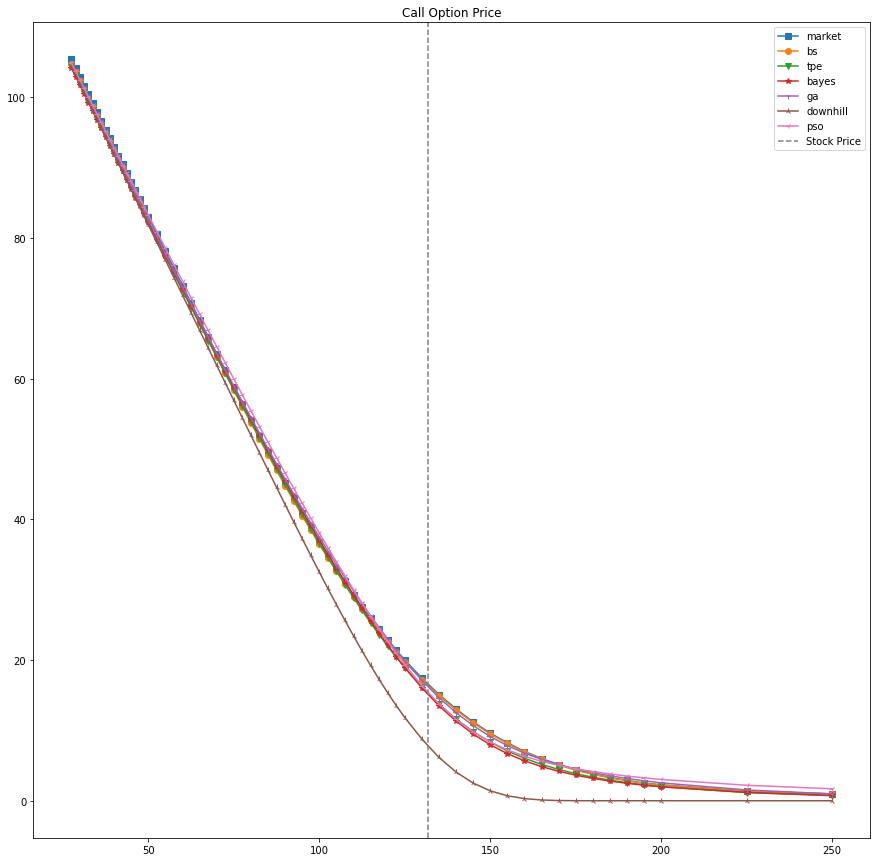

In [30]:
plt.figure(figsize=(15,15))
plt.plot(K2,market_price2,'s-',label='market')
plt.plot(K2,bs_price,'o-',label='bs')
plt.plot(K2,tpe_call_price,'v-',label='tpe')
plt.plot(K2,bayes_call_price,'*-',label='bayes')
plt.plot(K2,ga_call_price,'1-',label='ga')
plt.plot(K2,ds_call_price,'2-',label='downhill')
plt.plot(K2,pso_call_price,'3-',label='pso')
plt.axvline(x=S2,color='grey',linestyle='--',label='Stock Price')
plt.legend()
plt.title('Call Option Price')
plt.show()

In [31]:
def DIFF(real,predict):
    diff = []
    for i in range(len(real)):
        d = abs(real[i] - predict[i])
        diff.append(d)
    return diff

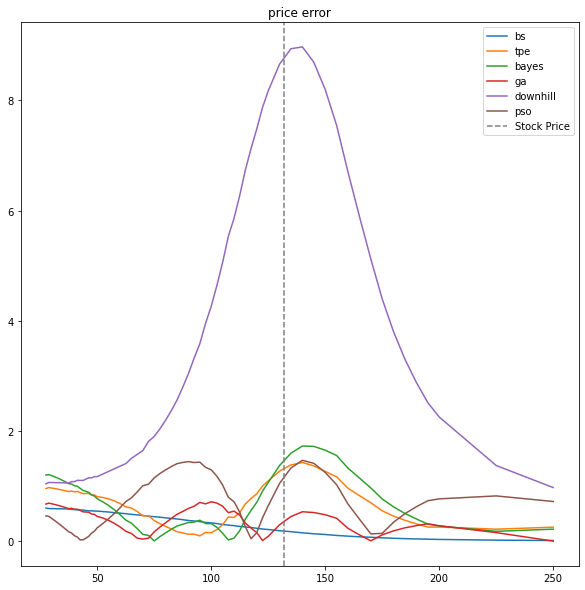

In [32]:
plt.figure(figsize=(10,10))
plt.plot(K2,DIFF(market_price2,bs_price),label='bs')
plt.plot(K2,DIFF(market_price2,tpe_call_price),label='tpe')
plt.plot(K2,DIFF(market_price2,bayes_call_price),label='bayes')
plt.plot(K2,DIFF(market_price2,ga_call_price),label='ga')
plt.plot(K2,DIFF(market_price2,ds_call_price),label='downhill')
plt.plot(K2,DIFF(market_price2,pso_call_price),label='pso')
plt.axvline(x=S2,color='grey',linestyle='--',label='Stock Price')
plt.legend()
plt.title('price error')
plt.show()

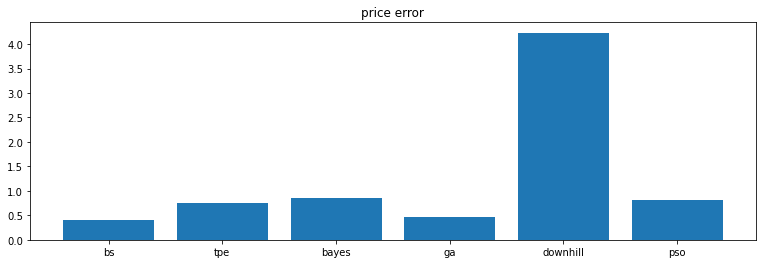

In [33]:
x = np.arange(6)
x_name = ['bs','tpe','bayes','ga','downhill','pso']
y = [RMSE(market_price2,bs_price),RMSE(market_price2,tpe_call_price),RMSE(market_price2,bayes_call_price),RMSE(market_price2,ga_call_price),RMSE(market_price2,ds_call_price),RMSE(market_price2,pso_call_price)]
plt.figure(figsize=(13,4))
plt.bar(x,y)
plt.xticks(x, x_name)
plt.title('price error')
plt.show()

In [34]:
t_tpe = 248
t_bayes = 1203.0872356891632
ga = 3374.996951818466
downhill = 208.34584712982178
pso = 1453.2291371822357

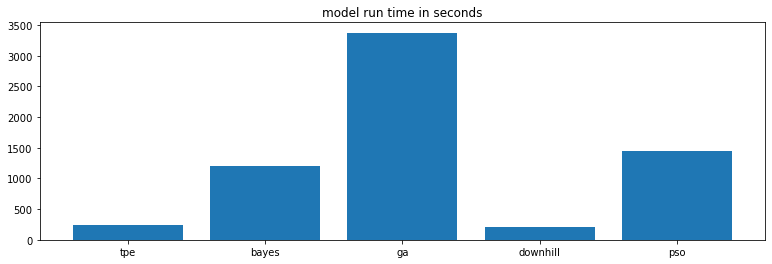

In [35]:
x2 = np.arange(5)
x_name2 = ['tpe','bayes','ga','downhill','pso']
t = [t_tpe,t_bayes,ga,downhill,pso]
plt.figure(figsize=(13,4))
plt.bar(x2,t)
plt.xticks(x2, x_name2)
plt.title('model run time in seconds')
plt.show()